In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [220]:
# read in data that includes county-level population density and time-series death counts 
df_density = pd.read_csv("/Users/yujiazhang/Downloads/covid_county_data (1).csv")
df_density.head()

,Unnamed: 0,date,county_name,long_county_name,state,pop_density,population,death_count
0,0,1/22/20,Autauga,"Autauga, Alabama, US",Alabama,91.8,55869,0
1,1,1/22/20,Baldwin,"Baldwin, Alabama, US",Alabama,114.6,223234,0
2,2,1/22/20,Barbour,"Barbour, Alabama, US",Alabama,31.0,24686,0
3,3,1/22/20,Bibb,"Bibb, Alabama, US",Alabama,36.8,22394,0
4,4,1/22/20,Blount,"Blount, Alabama, US",Alabama,88.9,57826,0


In [221]:
# Get county names; 3140 counties in total
# Moreover, we need long county names because some county names appear more than once 
# (e.g. Bibb, Alabama and Bibb, Georgia)

county_names = df_density['county_name'][0:3140]
long_county_names = df_density['long_county_name'][0:3140]

# Create county_reg dataframe for regression
county_reg = pd.DataFrame({'county name' : long_county_names})

# get population density of each county and store in regression df; this will be our covariate
# unit: number of people / square mile

pop_density = df_density['pop_density'][0:3140]
county_reg['pop_density'] = pop_density

county_reg.head()

,county name,pop_density
0,"Autauga, Alabama, US",91.8
1,"Baldwin, Alabama, US",114.6
2,"Barbour, Alabama, US",31.0
3,"Bibb, Alabama, US",36.8
4,"Blount, Alabama, US",88.9


In [ ]:
# specify a cutoff date, roughly ~ 2 weeks after social distancing measures are enforced
# we only consider data before the cutoff date because those are representative of the 
# infection trends without distancing

cutoffdate = np.where(A['date'] == '4/5/20')[0][0]


In [222]:
# define function to compute difference in log of a given array
# in order to get an estimate for ln(alpha) for each county

def diff_log(x, nsmooth=4):
    
    n = len(x)
    output=[]
    
    if n == 1:
        # if the input has length 1, i.e. new deaths occurred right before cutoff date,
        # return 0, as it doesn't give much signal about how the infection grows
        # (This could be improved)
        
        return 0
    
    elif n > 1:
        # if the input has length > 1, compute the difference in log of successive entries
        
        for i in range(1,n):
            output.append(np.log(x[i]) - np.log(x[i-1]))
        
        if n < nsmooth:           
            # if the length of input is smaller than smoothing radius
            # just take the mean of the difference-in-log array
            
            return np.mean(output)
        else:            
            # if the length of the input is larger than the smoothing radius
            # compute the mean of the last <nsmooth> terms of the diff-in-log array
            
            return np.mean(output[-nsmooth:])
    

In [231]:
# loop over all counties, decide whether to include them in the regression or not,
# and estimate their ln(alpha) based on growth in death counts

valid = np.zeros(3140)
difflog = np.zeros(3140)

for i in range(len(county_names)):
    #print(county_names[i])
    # for each county, start computing after the occurrence of the first death
    county = df_density[df_density['long_county_name'] == long_county_names[i]]
    
    # find the time of the first death
    if any(county['death_count']>=1):
        first_death_time = np.min(np.where(county['death_count']>=1))
    
        if first_death_time >= cutoffdate:
            # if the first death of the county occurred after the last day of interest
            # we do not include this county in the regression
        
            valid[i] = False
        
        else:
            # if the first death occurred before the last day of interest
            # include it in the regression, and estimate difference-in-log(deaths) value
            valid[i] = True
            valid_death_counts = county['death_count'][first_death_time : (cutoffdate+1)]
            difflog[i] = diff_log(valid_death_counts.values)
    else:
        valid[i] = False

/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [225]:
# store the above values in the regression dataframe
county_reg['valid for reg'] = valid
county_reg['diff_log(deaths)'] = difflog
county_reg.head()

In [227]:
# extract valid ones for regression

county_reg_valid  = county_reg[county_reg['valid for reg']==1]
county_reg_valid.head()

,county name,pop_density,valid for reg,diff_log(deaths)
1,"Baldwin, Alabama, US",114.6,1.0,0.000000
8,"Chambers, Alabama, US",57.4,1.0,0.101366
21,"Cullman, Alabama, US",109.4,1.0,0.000000
27,"Etowah, Alabama, US",195.2,1.0,0.274653
34,"Houston, Alabama, US",175.1,1.0,0.000000


Text(0, 0.5, 'log(alpha)')

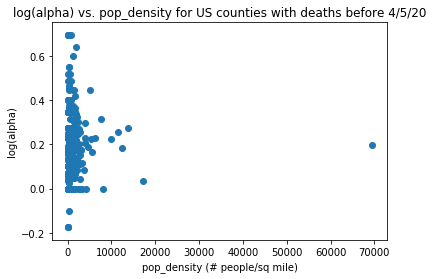

In [229]:
# plot diff_log(deaths) against population density

plt.scatter(county_reg_valid['pop_density'], county_reg_valid['diff_log(deaths)'])
plt.title('log(alpha) vs. pop_density for US counties with deaths before 4/5/20')
plt.xlabel('pop_density (# people/sq mile)')
plt.ylabel('log(alpha)')

Text(0, 0.5, 'log(alpha)')

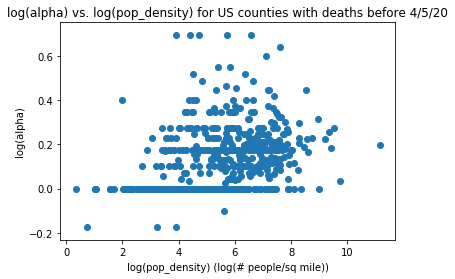

In [228]:
# plot diff_log(deaths) against log(population density)

plt.scatter(np.log(county_reg_valid['pop_density']), county_reg_valid['diff_log(deaths)'])
plt.title('log(alpha) vs. log(pop_density) for US counties with deaths before 4/5/20')
plt.xlabel('log(pop_density) (log(# people/sq mile))')
plt.ylabel('log(alpha)')

In [236]:
# linear regression on pop density and diff_log(deaths)
# results are invalid. probably there's a bug somewhere
# will look at nonlinear regression tomorrow

covariates = np.transpose(np.log(county_reg_valid['pop_density']))
covariates = sm.add_constant(covariates)
mod = sm.OLS(county_reg_valid['diff_log(deaths)'], covariates)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       diff_log(deaths)   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 16 Apr 2020   Prob (F-statistic):                nan
Time:                        00:49:02   Log-Likelihood:                    nan
No. Observations:                 697   AIC:                               nan
Df Residuals:                     695   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const              nan        nan        nan      